In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime as dt

In [2]:
%%time
# Using pyarrow to read the CSV to save on RAM

df = pd.read_csv(
    "Output/Bike usage VS Weather - NYC - 2022.csv",
    engine="pyarrow",                 # faster & lower memory
    dtype_backend="pyarrow",          # compact Arrow dtypes for ints/strings
    parse_dates=["started_at"],       # avoids huge object strings
)

df.columns

CPU times: user 22.4 s, sys: 5.87 s, total: 28.3 s
Wall time: 18 s


Index(['', 'ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual', 'date', 'avgTemp', 'precipitation'],
      dtype='object')

In [3]:
# Loading the weather dataframe from previous task (I added a CSV export when creating the DF in the previous code)

df_weather = pd.read_csv('Output/Weather NYC 2022.csv', index_col = 0)
df_weather.columns

Index(['date', 'avgTemp', 'precipitation'], dtype='object')

<Axes: xlabel='date'>

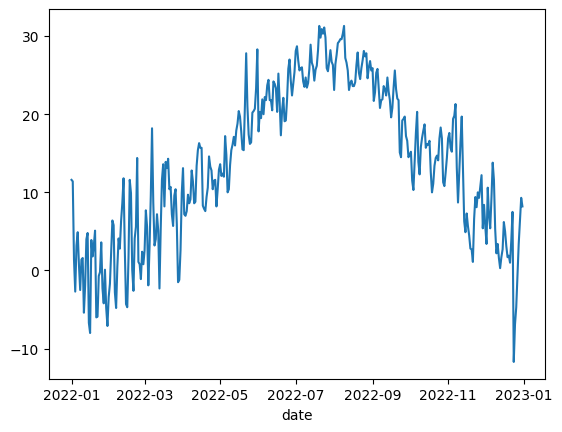

In [4]:
# Visualizing the averages temperatures during the year

df_weather['date'] = pd.to_datetime(df_weather['date'], format='%Y-%m-%d').dt.date
df_weather = df_weather.set_index('date')
df_weather['avgTemp'].plot()

In [ ]:
%%time
# Counting trips per day

df['date'] = pd.to_datetime(df['date'], errors='coerce')
df_ridecount = pd.DataFrame(df.groupby(['date'])['ride_id'].count()).reset_index()
df_ridecount

Some data is corrupted: in the 2022 CSV files imported from citibike, there are some trips dated in 2021
Going through the dataframe to remove the bad data takes too much RAM so I'll just recreate the dataframe omitting the corrupted entries

In [13]:
%%time
# First we free up some RAM by clearing the large open dataframe

# remove all references (including IPython's hidden ones)
%xdel df
from IPython import get_ipython
ip = get_ipython()
ip.run_line_magic('reset', '-f out')  # clear Out[] cache so big reprs aren’t pinned

import gc
gc.collect()  # sweep cyclic refs


# Then we import the data again from the CSV files but omitting data with not-2022 dates

from pathlib import Path

filepaths = [p for p in Path("Data").rglob("*.csv")
             if p.is_file() and not any(part.startswith(".") for part in p.parts)]

out = Path("Output/bike_data_cleaned_2022.csv")
out.unlink(missing_ok=True)  # ensure we start fresh

out = "Output/bike_data_cleaned_2022.csv"; first = True
for f in filepaths:
    for chunk in pd.read_csv(f, chunksize=500_000, low_memory=False):
        ts = pd.to_datetime(chunk['started_at'], errors='coerce')
        keep = (ts >= '2022-01-01') & (ts < '2023-01-01')
        if keep.any():
            chunk.loc[keep].to_csv(out, mode="a", index=False, header=first)
            first = False

NameError: name 'df' is not defined
Flushing output cache (3 entries)
CPU times: user 2min 55s, sys: 10.3 s, total: 3min 6s
Wall time: 3min 8s


In [7]:
%%time
#Importing the result into a new DF

# Using pyarrow to read the CSV to save on RAM
df_cleaned = pd.read_csv(
    "Output/bike_data_cleaned_2022.csv",
    engine="pyarrow",                 # faster & lower memory
    dtype_backend="pyarrow",          # compact Arrow dtypes for ints/strings
    parse_dates=["started_at"],       # avoids huge object strings
)

df_cleaned.columns


CPU times: user 17.6 s, sys: 7.95 s, total: 25.6 s
Wall time: 22.2 s


Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual'],
      dtype='object')

In [8]:
# Add a date column
df_cleaned['date'] = pd.to_datetime(df_cleaned['started_at'])
df_cleaned['date'] = pd.to_datetime(df_cleaned['date'], format='%Y-%m-%d').dt.date

In [9]:
# Counting trips per day with clean data

df_ridecount = pd.DataFrame(df_cleaned.groupby(['date'])['ride_id'].count()).reset_index()
df_ridecount = df_ridecount.set_index('date')
df_ridecount.rename(columns={'ride_id':'rides'}, inplace = True)
df_ridecount

,rides
date,
2022-01-01,20428
2022-01-02,43009
2022-01-03,33189
2022-01-04,36842
2022-01-05,34230
...,...
2022-12-27,33044
2022-12-28,44027
2022-12-29,51674


In [10]:
# Merge ride count and weather

df_merged = df_weather.merge(df_ridecount, on = "date", how = 'outer', indicator = True)
df_merged

,avgTemp,precipitation,rides,_merge
date,,,,
2022-01-01,11.6,19.3,20428,both
2022-01-02,11.4,1.0,43009,both
2022-01-03,1.4,0.0,33189,both
2022-01-04,-2.7,0.0,36842,both
2022-01-05,3.2,6.1,34230,both
...,...,...,...,...
2022-12-27,-0.7,0.0,33044,both
2022-12-28,3.4,0.0,44027,both
2022-12-29,6.4,0.0,51674,both


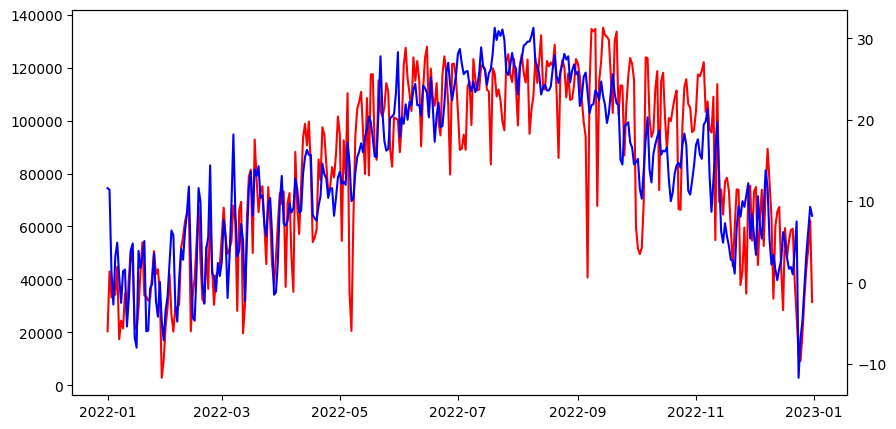

In [11]:
# Dual plot of ride count VS temperature

# Create figure and axis objects with subplots()

fig,ax = plt.subplots(figsize=(10, 5))

# Make a plot of the bike rides
ax.plot(df_merged['rides'],color = "red")

# Here is where we create the dual axis - initialize a twin object for two different y-axis on the sample plot
ax2 = ax.twinx()

# Make a plot with the temperatues on the y-axis using second axis object
ax2.plot(df_merged["avgTemp"], color = "blue")
plt.show()

We used an Object Oriented approach: creating 2 subplot objects and merging them into a "twin plot" using methods of the subplot object.